
# Clothing classification using a Multi-Layer Perceptron

A clothing classification project using a Multi-Layer Perceptron to practice PyTorch. This project uses the Fashion MNIST dataset that you can find here on Kaggle : https://www.kaggle.com/datasets/zalando-research/fashionmnist
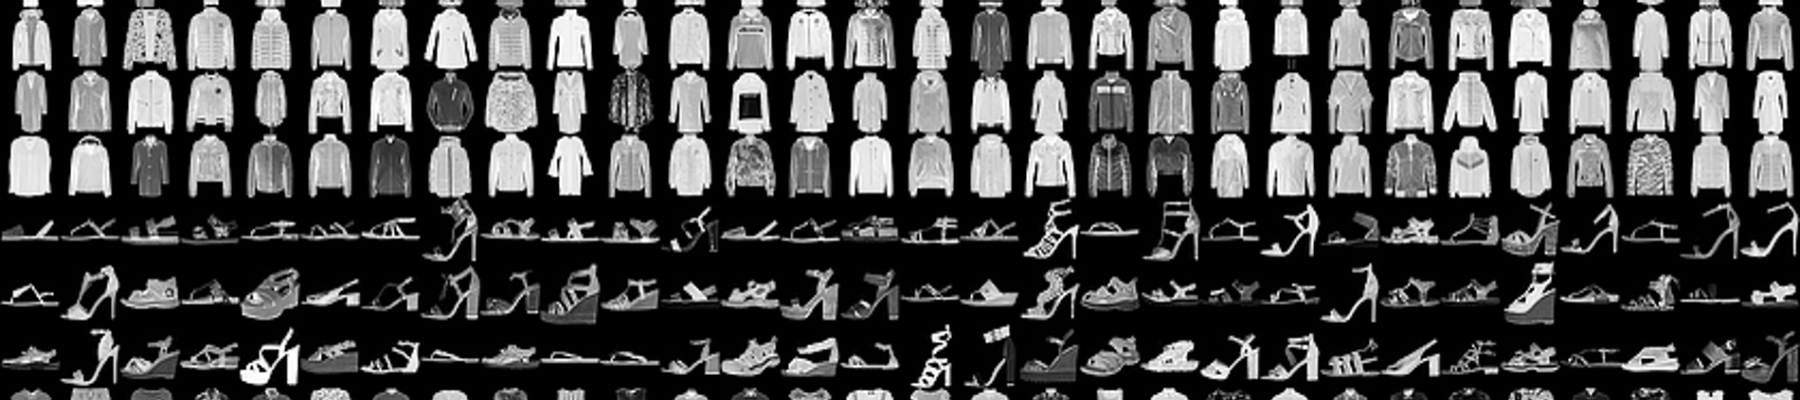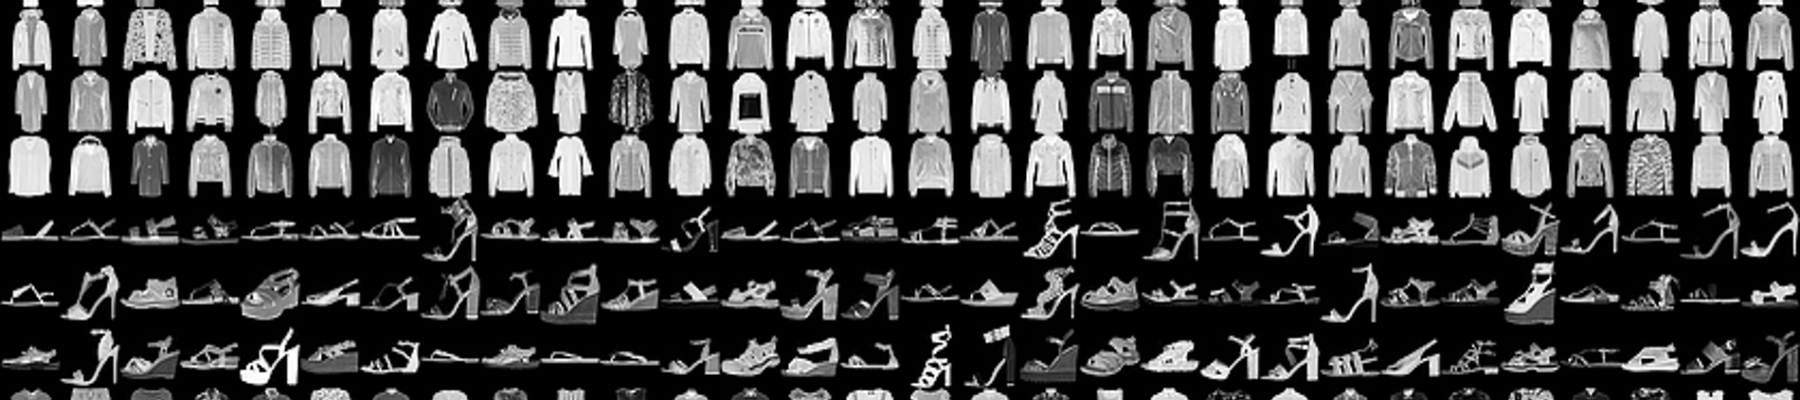

## 1) Training

In [1]:
# To view Model Summary
!pip install -q torchinfo

In [2]:
import torch
from torch import nn
import torch.nn.functional as F
import torch.optim as optim
from torchinfo import summary

import torchvision
from torchvision import datasets, transforms

import matplotlib.pyplot as plt
import numpy as np
import random
import time

%matplotlib inline

In [3]:
# set seed for reproductibility when using random numbers
def set_seeds():
    # set random seed value
    SEED_VALUE = 756

    # set seed for python's random module
    random.seed(SEED_VALUE)
    # set seed for NumPy to ensure rerpoductibility in operations involving randomness
    np.random.seed(SEED_VALUE)
    # set seed for pytorch to ensure consistent initialization of weights, etc
    torch.manual_seed(SEED_VALUE)

    # if CUDA (GPU support) is avialable, set additional seed to control randomness in GPU operations
    # Fix seed to make training deterministic.
    if torch.cuda.is_available():
        torch.cuda.manual_seed(SEED_VALUE) # for single GPU operations
        torch.cuda.manual_seed_all(SEED_VALUE) # for multi-GPU operations
        # ensures deterministic behavior of cuDNN (cuda Deep Neural Network) operations
        torch.backends.cudnn.deterministic = True
        # enbaling cuDNN benchmarking mode can improve training speed for fiex input size
        torch.backends.cudnn.benchmark = True

set_seeds()

In [4]:
# transforms are operations to apply to images. transforms.ToTensor() creates a transform operation that convert PIL image or numpy array to Tensors
# and divide values by 255 to have all values between 0 and 1
raw_transform = transforms.Compose([transforms.ToTensor()])
# Step 1 : download the training set without normalization
training_set_raw = datasets.FashionMNIST(root="F_MNIST_data", download=True, train=True, transform=raw_transform)

# Step 2 : concatenate given sequence of tensors, flatten value as a 1-dimension vector and compute mean and variance from the training set
all_pixels = torch.cat([img.view(-1) for img, _ in training_set_raw])
mean = all_pixels.mean().item()
variance = all_pixels.std().item()

print(f"Computed Mean : {mean : .4f}, Computed Std : {variance:.4f}")

# Step 3 : Define the new transform using the computed mean and variance
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((mean,), (variance,))
])

# Step 4 : reload datasets with proper normalization
train_set = datasets.FashionMNIST(root="F_MNIST_data", download=True, train=True, transform=transform)
validation_set = datasets.FashionMNIST(root="F_MNIST_data", download=True, train=False, transform=transform)

print("Total Train Images : ", len(train_set))
print("Total Validation Images : ", len(validation_set))

Computed Mean :  0.2860, Computed Std : 0.3530
Total Train Images :  60000
Total Validation Images :  10000


In [5]:
# defining data loaders for training and testing datasets
# To avoid the MLP network from learning the sequence pattern in the dataset we shuffle the train dataset
train_loader = torch.utils.data.DataLoader(train_set, shuffle = True, batch_size = 64)
# we do not need to shuffle validation data set as it takes time (in training we want to avoid biases, but we aren't learning anymore)
validation_loader = torch.utils.data.DataLoader(validation_set, shuffle = False, batch_size = 64)

In [6]:
# map class to index
class_mapping = {
    0: "T-shirt/top",
    1: "Trouser",
    2: "Pullover",
    3: "Dress",
    4: "Coat",
    5: "Sandal",
    6: "Shirt",
    7: "Sneaker",
    8: "Bag",
    9: "Ankle boot"  }

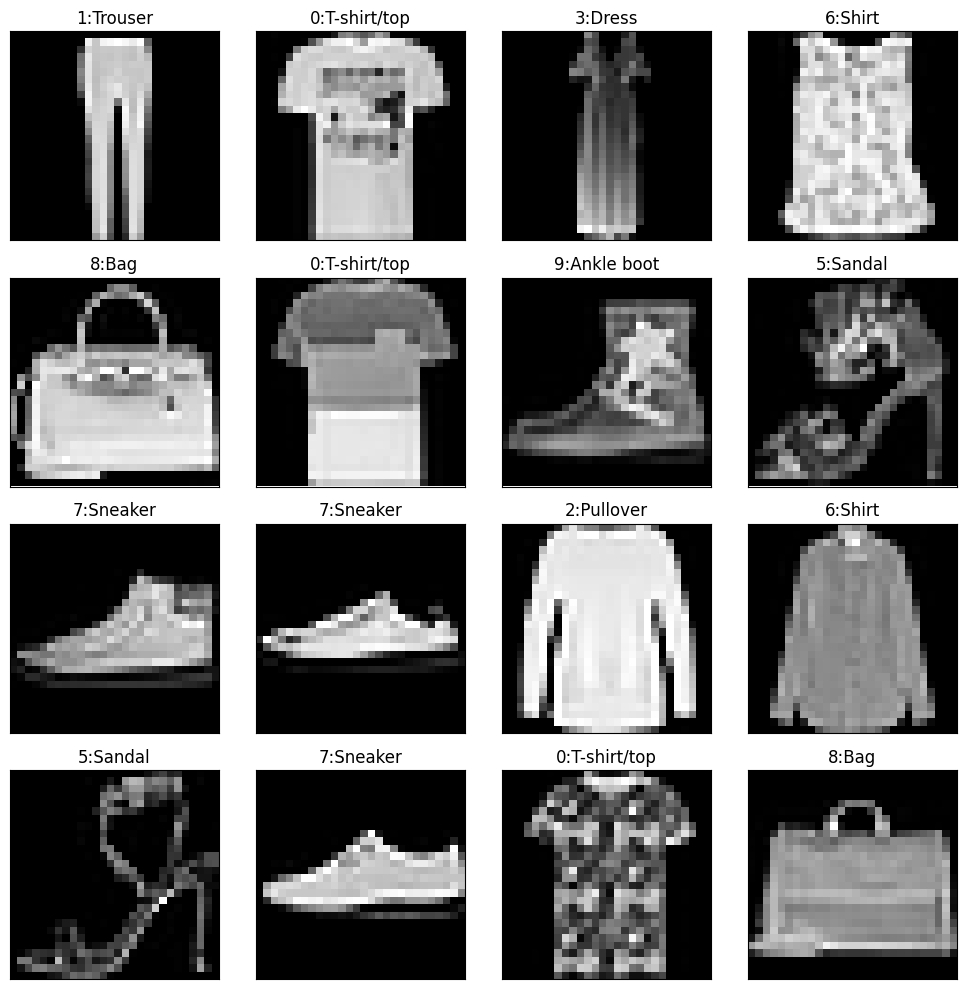

In [7]:
def visualize_images(trainloader, num_images=20):
    """
    Function to visualize a batch of images from the training loader.

    @param trainloader: PyTorch DataLoader containing training images and labels, a DataLoader
    @param num_images : the number of images to display, an integer.
    """
    fig = plt.figure(figsize=(10, 10))

    # Iterate over the first batch : retrieve the first batch of images and labels from the trainloader
    images, labels = next(iter(trainloader))

    # calculate the number of rows and columns for subplots
    num_rows = 4 # fixed rows for the grid
    num_cols = int(np.ceil(num_images / num_rows))

    # loop through the images up to the specified number
    for idx in range(min(num_images, len(images))):
      image, label = images[idx], labels[idx] # extract individual image and label

      ax = fig.add_subplot(num_rows, num_cols, idx+1, xticks=[], yticks=[])
      ax.imshow(np.squeeze(image), cmap="gray")
      ax.set_title(f"{label.item()}:{class_mapping[label.item()]}")

    fig.tight_layout()
    plt.show()

visualize_images(train_loader, num_images=16)

In [8]:
class MLP(nn.Module):
    """
    A Multi-Layer Percpetron model for classification tasks.
    This MLP consists of five fully connected layers with batch normalization, ReLU activations, and dropout for regularization.
    """

    def __init__(self, num_classes):
        """
        Initializes the MLP model with the given number of output classes.
        @param num_classes : the number of output classes for classification, an integer.
        """
        super().__init__()

        # Fully connected layers with decreasing number of neurons
        self.fc0 = nn.Linear(784, 512) # Input layer : 784 (28x28 flattened) -> 512 neurons
        self.bn0 = nn.BatchNorm1d(512) # Batch normalization for stability

        self.fc1 = nn.Linear(512, 256) # Hidden layer : 512 -> 256 neurons
        self.bn1 = nn.BatchNorm1d(256)

        self.fc2 = nn.Linear(256, 128) # Hidden layer : 256 -> 128 neurons
        self.bn2 = nn.BatchNorm1d(128)

        self.fc3 = nn.Linear(128, 64) # Hidden layer : 128 -> 64 neurons
        self.bn3 = nn.BatchNorm1d(64)

        self.fc4 = nn.Linear(64, num_classes) # Output layer : 64 -> num_classes neurons

        # Dropout layer to reduce overfitting (p=0.3 means 30% dropout)
        # The dropout randomly deactivates somes neurons during training to reduce overfitting by avoiding MLP to memorize the dataset,
        # become dependant of only a few neurons, etc
        self.dropout = nn.Dropout(p=0.3)

    def forward(self, x):
        """
        Forward pass through the network.
        @param x : Input Tensor of shape (batch_size, 1, 28, 28) (for MNIST-like data), a torch.Tensor.
        @return log-probabilities of each class (after applying log_softmax), a torch.Tensor.
            
        """
        # Flatten the input tensor from (batch_size, 1, 28, 28) to (batch_size, 784)
        x = x.view(x.shape[0], -1) # reshaping for compatibility with fully connected layers

        # First fully connected layer : Linear -> BatchNorm -> ReLU -> Dropout
        x = F.relu(self.bn0(self.fc0(x)))
        x = self.dropout(x) # Apply dropout

        # second fully connected layer : Linear -> BatchNorm -> ReLU
        x = F.relu(self.bn1(self.fc1(x)))

        # Third fully connected layer : Linear -> BatchNorm -> RelU -> dropout
        x = F.relu(self.bn2(self.fc2(x)))
        x = self.dropout(x) # Apply dropout

        # Fourth fully connected layer : Linear -> BatchNorm -> ReLU
        x = F.relu(self.bn3(self.fc3(x)))

        # Output layer : Linear -> Log Softmax (for classification)
        x = F.log_softmax(self.fc4(x), dim=1) # log probabilities for each class

        return x

# Instantiate the model with 10 output classes (e.g., for MNIST)
mlp_model = MLP(num_classes=10)

In [9]:
# Display the model summary using summary from torchinfo
print(summary(mlp_model, input_size = (1, 1, 28, 28), row_settings = ["var_names"]))

Layer (type (var_name))                  Output Shape              Param #
MLP (MLP)                                [1, 10]                   --
├─Linear (fc0)                           [1, 512]                  401,920
├─BatchNorm1d (bn0)                      [1, 512]                  1,024
├─Dropout (dropout)                      [1, 512]                  --
├─Linear (fc1)                           [1, 256]                  131,328
├─BatchNorm1d (bn1)                      [1, 256]                  512
├─Linear (fc2)                           [1, 128]                  32,896
├─BatchNorm1d (bn2)                      [1, 128]                  256
├─Dropout (dropout)                      [1, 128]                  --
├─Linear (fc3)                           [1, 64]                   8,256
├─BatchNorm1d (bn3)                      [1, 64]                   128
├─Linear (fc4)                           [1, 10]                   650
Total params: 576,970
Trainable params: 576,970
Non-trainable

In [10]:
# Define the loss function
criterion = F.nll_loss # Negative Log Likelihood Loss, commonly used for classification tasks

# Define the optimizer : Adam optimizer with a learning rate of 0.01
optimizer = optim.Adam(mlp_model.parameters(), lr=1e-2)

# Number of epochs for training
num_epochs = 40 # the model will train for 40 complete passes over the dataset

# select the device for computation (GPU if available, otherwise CPU)
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

In [11]:
def train(model, trainloader, criterion, optimizer, device):
    """
    Trains the given model for one epoch using the provided training data.
    @param model : The neural network model to be trained, nn.Module.
    @param trainloader : DataLoader containing the training dataset, a DataLoader.
    @param criterion : Loss function used for optimization, a function.
    @param optimizer : Optimizer used for updating model weights (e.g., Adam, SGD), a torch.optim.Optimizer.
    @param device : Device to run the training on ("cuda" for GPU, otherwise "cpu"), a string.

    @return avg_loss : The average training loss over the entire dataset, a float.
    @return accuracy : The percentage of correctly classified samples in the training set, a float.
    """
    # set model to training mode
    model.train()
    # Move model to the specified device (GPU/CPU)
    model.to(device)

    # initialize variables to track loss and accuracy
    running_loss = 0 # accumulate the total loss for averaging
    correct_predictions = 0 # counts the number of correct predictions
    total_samples = 0 # tracks the total number of processed samples

    # iterate over the training dataset
    for images, labels in trainloader:
        # move images and labels to the specified device (GPU/CPU)
        images,labels = images.to(device),labels.to(device)
        # reset gradients to prevent accumulation from previous batches
        optimizer.zero_grad()
        # forward pass : get model predictions
        outputs = model(images)

        # compute the loss between predictions and ground truth labels
        loss = criterion(outputs, labels)
        # Backpropagation : compute gradients
        loss.backward()
        # update model weights using the optimizer
        optimizer.step()

        # accumulate loss for averaging
        running_loss += loss.item()
        # get the predicted class with the highest probability
        _, predicted = torch.max(outputs.data, dim=1)
        # update total sample count
        total_samples += labels.size(0)
        # count correctly predicted samples
        correct_predictions += (predicted == labels).sum().item()

    # compute average loss accross all batches
    avg_loss = running_loss / len(trainloader)
    # compute training accuracy as a percentage
    accuracy = 100 * correct_predictions / total_samples
    
    return avg_loss, accuracy # return avergae loss and accuracy after one training epoch

In [12]:
def validation(model, val_loader, criterion, device):
    """
    Evaluates the given model on the validation dataset.
    @param model : The trained neural network model to be evaluated, a nn.Module.
    @param val_loader : Datalader containing the validation dataset, a DataLoader.
    @param criterion : loss function used to measuer model performance (e.g., Negative Log Likelihood Loss), a function.
    @param device : The device to run the evaluation on ("cuda" for GPU, "cpu" otherwise), a string.
    @return avg_loss : The average validation loss overt the dataset, a float.
    @return accuracy : The percentage of correctly classified samples in the validation set, a float.
    """
    # set the model to evaluation mode (disables dropout, batch norm behaves differently)
    model.eval()
    # move model to the specified device (GPU/CPU)
    model.to(device)

    # Initialize variables to track loss and accuracy
    running_loss = 0
    correct_predictions = 0
    total_samples = 0

    # Disable gradient computation to save memory and speed up inference
    with torch.no_grad():
        # iterate over the validation dataset
        for images, labels in val_loader:
            # move images and labels to the specified device (GPU/CPU)
            images,labels = images.to(device),labels.to(device)

            # Forward pass : get model prediction
            outputs = model(images)

            # compute loss between predictions and ground truth labels
            loss = criterion(outputs, labels)
            # accumulate loss for averaging
            running_loss += loss.item()
            # get the predicted class with the highest probability
            _, predicted = torch.max(outputs.data, 1) #(B, class_id)
            # update total sample count
            total_samples += labels.size(0)
            # count correctly predicted samples
            correct_predictions += (predicted == labels).sum().item()

    # compute average loss across all batches
    avg_loss = running_loss / len(val_loader)
    # compute validation accuracy as a percentage
    accuracy = 100 * correct_predictions / total_samples
    
    return avg_loss, accuracy

In [13]:
def main(model, training_loader, validation_loader, epochs=5, device = "cuda"):
    """
    Trains and validates the given model over multiple epochs and plots the results.
    @param model : The neural network model to be trained and validated, a nn.Module.
    @param training_loader : The Dataloader containing the training dataset, a DataLoader.
    @param validation_loader : The Dataloader containing the validation dataset, a DataLoader.
    @param epochs : The number of epochs to train the model, an integer.
    @param device : The device to run the training and validation on ("cuda" for GPU, otherwise "cpu").
    """
    # lists to store loss and accuracy values for plotting
    training_losses, validation_losses = [], []
    training_accuracies, validation_accuracies = [], []

    # training loop for multiple epochs
    for epoch in range(epochs):
        # train the model for one epoch
        training_loss, training_accuracy = train(model, training_loader, criterion, optimizer, device)
        # validate the model after training
        validation_loss, validation_accuracy = validation(model, validation_loader, criterion, device)

        # store losses and accuracies for analysis
        training_losses.append(training_loss)
        training_accuracies.append(training_accuracy)
        validation_losses.append(validation_loss)
        validation_accuracies.append(validation_accuracy)

        # print training progress for each epoch
        print(f"Epoch {epoch+1:0>2}/{epochs} - Training Loss: {training_loss:.4f}, Training Accuracy: {training_accuracy:.2f}% - Validation Loss: {validation_loss:.4f}, Validation Accuracy: {validation_accuracy:.2f}%")

    # Plotting loss and accuracy
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(range(1, epochs + 1), training_losses, label='Training Loss')
    plt.plot(range(1, epochs + 1), validation_losses, label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(range(1, epochs + 1), training_accuracies, label='Training Accuracy')
    plt.plot(range(1, epochs + 1), validation_accuracies, label='Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

Epoch 01/40 - Training Loss: 0.5593, Training Accuracy: 79.93% - Validation Loss: 0.4273, Validation Accuracy: 84.09%
Epoch 02/40 - Training Loss: 0.4380, Training Accuracy: 84.42% - Validation Loss: 0.3922, Validation Accuracy: 85.79%
Epoch 03/40 - Training Loss: 0.3987, Training Accuracy: 85.60% - Validation Loss: 0.3702, Validation Accuracy: 86.13%
Epoch 04/40 - Training Loss: 0.3752, Training Accuracy: 86.50% - Validation Loss: 0.3575, Validation Accuracy: 86.98%
Epoch 05/40 - Training Loss: 0.3543, Training Accuracy: 87.17% - Validation Loss: 0.3456, Validation Accuracy: 87.75%
Epoch 06/40 - Training Loss: 0.3412, Training Accuracy: 87.55% - Validation Loss: 0.3284, Validation Accuracy: 88.16%
Epoch 07/40 - Training Loss: 0.3246, Training Accuracy: 88.28% - Validation Loss: 0.3376, Validation Accuracy: 87.70%
Epoch 08/40 - Training Loss: 0.3131, Training Accuracy: 88.52% - Validation Loss: 0.3239, Validation Accuracy: 88.38%
Epoch 09/40 - Training Loss: 0.3027, Training Accuracy: 

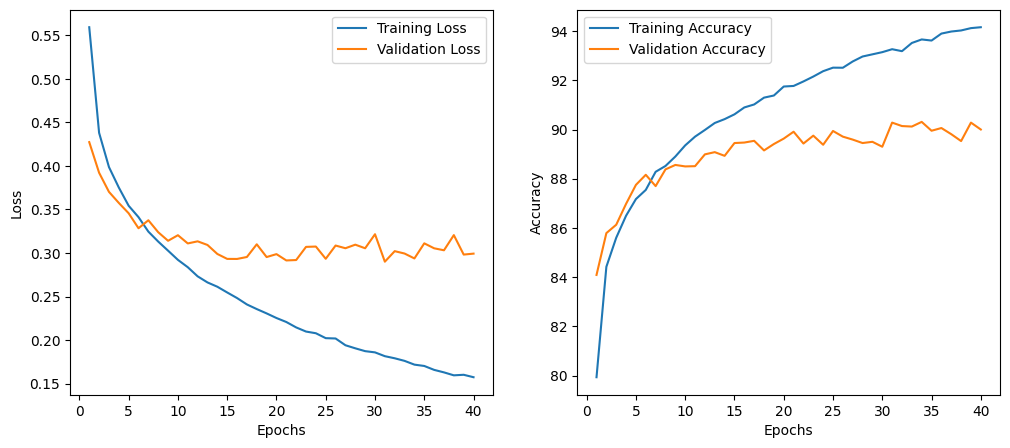

In [14]:
main(mlp_model, train_loader, validation_loader, epochs = num_epochs, device = DEVICE)


## 2) Results

With a learning rate of 0.01 our MLP Model achieved a highest validation accuracy of 90.31%. We can see that the validation accuracy stagnates after approximately 30 epochs, so maybe the 40 epochs weren't necessary.

We can now pick a random image inside the test dataset to see what the MLP predicts.


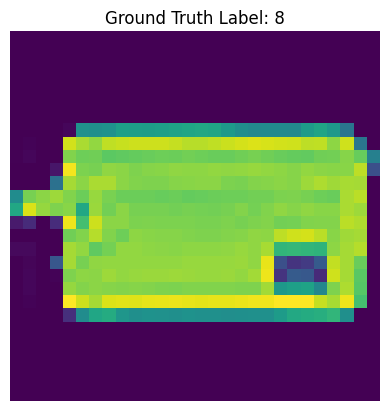

In [15]:
# Retrieve a batch of images and ground truth labels from the validation Dataloader
images, gt_labels = next(iter(validation_loader))

# Randomly select an index from the batch
random_index = random.choice(range(len(images)))

# Display the selected image
plt.imshow(images[random_index].squeeze())
plt.title("Ground Truth Label: " + str(int(gt_labels[random_index])), fontsize = 12)
plt.axis("off")
plt.show()

In [16]:
# Formatting
bold = f"\033[1m"
reset = f"\033[0m"

# set the model to evaluation mode (disables dropout and changes batch norm behavior)
mlp_model.eval()

# disabling gradient computation for efficiency during inference
with torch.no_grad():
    # perform forward pass with the selected batch of images on the specified device
     batch_outputs = mlp_model(images.to(DEVICE))

# compute softmax probabilities for each class in the batch
prob_score_batch = batch_outputs.softmax(dim=1).cpu() # move to cpu for easier processing

# extract the probability distribution for the randomly selected test imae
prob_score_test_image = prob_score_batch[random_index]
# get the predicted class ID (index of the highest probability)
pred_cls_id = prob_score_test_image.argmax()

print("Predictions for each class on the test image:\n")

# iterate over all class probabilities and print them
for idx, cls_prob in enumerate(prob_score_test_image):
    if idx == pred_cls_id:
       print(f"{bold}Class: {idx} - {class_mapping[idx]}, Probability: {cls_prob:.3f}{reset}")
    else:
       print(f"Class: {idx} - {class_mapping[idx]}, Probability: {cls_prob:.3f}")

Predictions for each class on the test image:

Class: 0 - T-shirt/top, Probability: 0.000
Class: 1 - Trouser, Probability: 0.000
Class: 2 - Pullover, Probability: 0.000
Class: 3 - Dress, Probability: 0.000
Class: 4 - Coat, Probability: 0.000
Class: 5 - Sandal, Probability: 0.000
Class: 6 - Shirt, Probability: 0.000
Class: 7 - Sneaker, Probability: 0.000
Class: 8 - Bag, Probability: 1.000
Class: 9 - Ankle boot, Probability: 0.000



## 5.1. Confusion matrix

Here is a confusion matrix of the prediction results for our MLP. The y-axis represents the ground truth labels for each class, and the x one represents the predicted labels from our network.


In [17]:
# importing the confusion_matrix function from scikit-learn to evaluate classification performance
from sklearn.metrics import confusion_matrix
# importing seaborn, a statistical data visualization library, to create a heatmap for the confusion matrix
import seaborn as sn

def prediction_batch(model, batch_inputs):
    """
    Performs batch prediction using training model.
    @param model : The trained neural network model for inference, a nn.Module.
    @param batch_inputs : The batch of input data for which predictions are to be made, a torch.Tensor.
    """
    # set model to evaluation mode
    model.eval()

    # perform forward pass to get raw model outputs
    batch_outputs = model(batch_inputs)

    with torch.no_grad():
        # convert logits to probabilities using softmax along the class dimension
        batch_probs = batch_outputs.softmax(dim=1) #along num of classes dimension

    # get the predicted class index for each sample (the class with the highest probability)
    batch_cls_ids = batch_probs.argmax(dim=1)

    # move the predictions to the CPU for easier access
    return batch_cls_ids.cpu()

In [18]:
# lists to store ground truth labels and model predictions
validation_target_labels = []
validation_predicted_labels = []

# iterate over the validation datatset in batches
for image_batch, target_batch in validation_loader:
    # move the batch of images to specified device
    image_batch = image_batch.to(DEVICE)

    # get model predictions for the current batch
    batch_pred_cls_id = prediction_batch(mlp_model, image_batch)

    # store predicted class labels
    validation_predicted_labels.append(batch_pred_cls_id)

    # store ground truth labels (target labels)
    validation_target_labels.append(target_batch)

# convert the list of tensors into a single tensor, then into a NumPy array
validation_target_labels = torch.cat(validation_target_labels).numpy()
validation_predicted_labels = torch.cat(validation_predicted_labels).numpy()

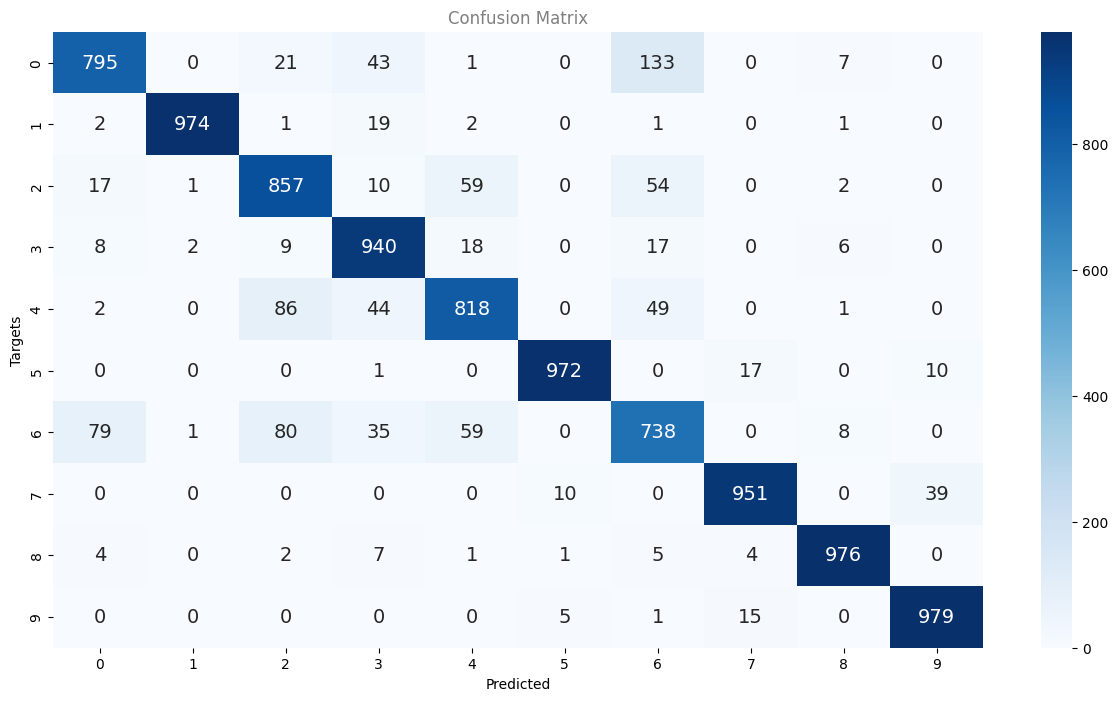

In [19]:
# compute the confusion matrix
cm = confusion_matrix(y_true=validation_target_labels, y_pred=validation_predicted_labels)

# set figure size for better visibility
plt.figure(figsize=[15,8])

# plot he confusion matrix as heatmap using seaborn
sn.heatmap(cm, annot=True, fmt='d', annot_kws={"size":14}, cmap="Blues")

plt.xlabel("Predicted")
plt.ylabel("Targets")
plt.title(f"Confusion Matrix", color="gray")
plt.show()